# Part 1 - Generate hydrographs from digital elevation model (DEM)
This notebook demonstrates with a small examplary region (basin upstream of Altenahr, West Germany) how geomorphological unit hydrographs can be derived from a digital elevation model with a spatial resolution of 25m x 25m. Later on the hydrographs are the basis for the quick runoff (QR) modelling and allow for a large number of counterfacual simulations (see notebook XXXXXX.ipynb).

In [6]:
import counterfactual_preparation as cp
from IPython.display import Image
import geopandas as gpd
import glob
import os
import shutil

## Creation of basic rasters
At first we just need a DEM. Follwing rasters are then created using PCRaster functions. The detailed code can be viewed in the script `counterfactual functions.py`. All results are stored in the folder "input/generated". The coordinate reference system for all files is "EPSG:3035".

Following data is supplied in this repository in the filder **input**:
- **dem.map**: DEM (ref) of the region of the Altenahr basin
- **corine.gpkg**: CORINE (ref) landuse file of the Altenahr basin
- **buek250_cn_classes.gpkg**: soil classes derived from soil map BUEK250 (ref) and manually classified to four soil classes according to the SCS-CN method (ref).
- **scs.csv**:table which connects CORINE landuse codes (CLC18) to curve number values
- **cn_sm_classes.csv**: table of increasing curve numbers for soil moisture class 2 and the corresponding values for soil moisture class 1 and 2.

Following data sets are computed in this step and saved in **output/gis**. These files are the basis for the computation of hydrographs.

- sink filling is applied to the DEM (**dem_filled.map**)
- flow direction grid (**flowdir.map**)
- flow accumulation grid (**accu.map**)
- raster and shapefile containing the subbasins (**subbasins.gpkg**, **subbasins_adjusted.map**)
- raster containing the friction values, needed for traveltime calculation (**friction_maidment.map**)
- raster containing the traveltime (in minutes, based on the method by Maidment et al., 1996) of every cell to its respective outlet (**tt_complete.map**)
- shapefile containing the curve number values for every basin and soil moisture class (**soil_landuse_classes.gpkg**). This file is derived from the soil map BUEK250 and the
 landuse (files **buek250_cn_classes.gpkg** and **corine.gpkg**)
Outlets are determined by the intersection of streams with the Strahler-oder 7 upwards with the functions cf.create_outlet_raster and cf.find_intersects and stored in the raster "outlets.map".

Then outlet and flow direction raster are used to delineate the subbasins. Very small subbasins (< 0.45 km²) are removed with the function `counterfactual_functions.remove_small_subbasins`.

In [2]:
files = glob.glob('output/gis/*')
print("Removing previous files")
for f in files:
    os.remove(f)

if not os.path.exists("output"):
    os.mkdir("output")

if not os.path.exists("output/gis"):
    os.mkdir("output/gis")

Removing previous files


In [3]:
#this step takes about a minute
cp.create_basic_files("input/")

Filling DEM
Creating flow direction grid
Creating accumulation grid
Creating subbasin shape file and raster
Removed 16 outlets
The basin now contains 57 subbasins
0...10...20...30...40...50...60...70...80...90...Creating output output/gis/subbasins_first.gpkg of format GPKG.
100 - done.
Making maidment friction map
Number of outlets: 58
2023-12-21 09:24:53.196031 Creating traveltime raster
2023-12-21 09:24:53.839865 Creating soil landuse shape file for curve number method


<Axes: >

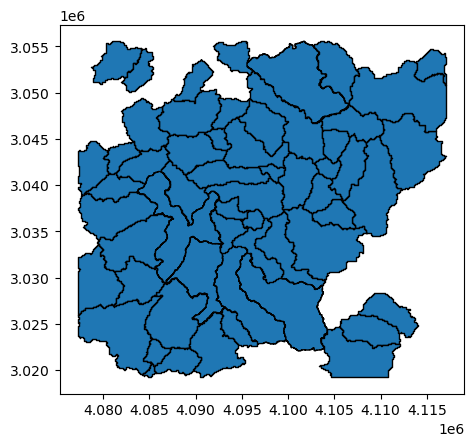

In [4]:
subbasins = gpd.read_file("output/gis/subbasins.gpkg")
subbasins.plot(edgecolor="black")

## Create the files for the individual subbasins
Now that the basic rasters for the whole area have been generated, we can clip the results to the individual subbasins and calculate the hydrographs and curve numbers for each subbasin. The results are stored in **output/basins** and are the basis for the hydrological modelling later on. Plots of the hydrographs and the traveltimes rasters for every subbasin are stored in **output/giuh_plots**. 

In [5]:
#clean up if you want to compute the hydrographs again
files = glob.glob('output/basins/*')
print("Removing previous basin files")
for f in files:
    shutil.rmtree(f)
    
files = glob.glob('output/giuh_plots/*')
print("Removing previous plots")
for f in files:
    os.remove(f)

Removing previous basin files
Removing previous plots


In [ ]:
subbasins = gpd.read_file("output/gis/subbasins.gpkg")
cp.hydrograph_and_cn_for_subbasins(subbasins.DN.to_list(), plot_giuh=True)

### View results
Here you can view the traveltime raster and corresponding hydrographs for every subbasin. Just change the subbasin id below.

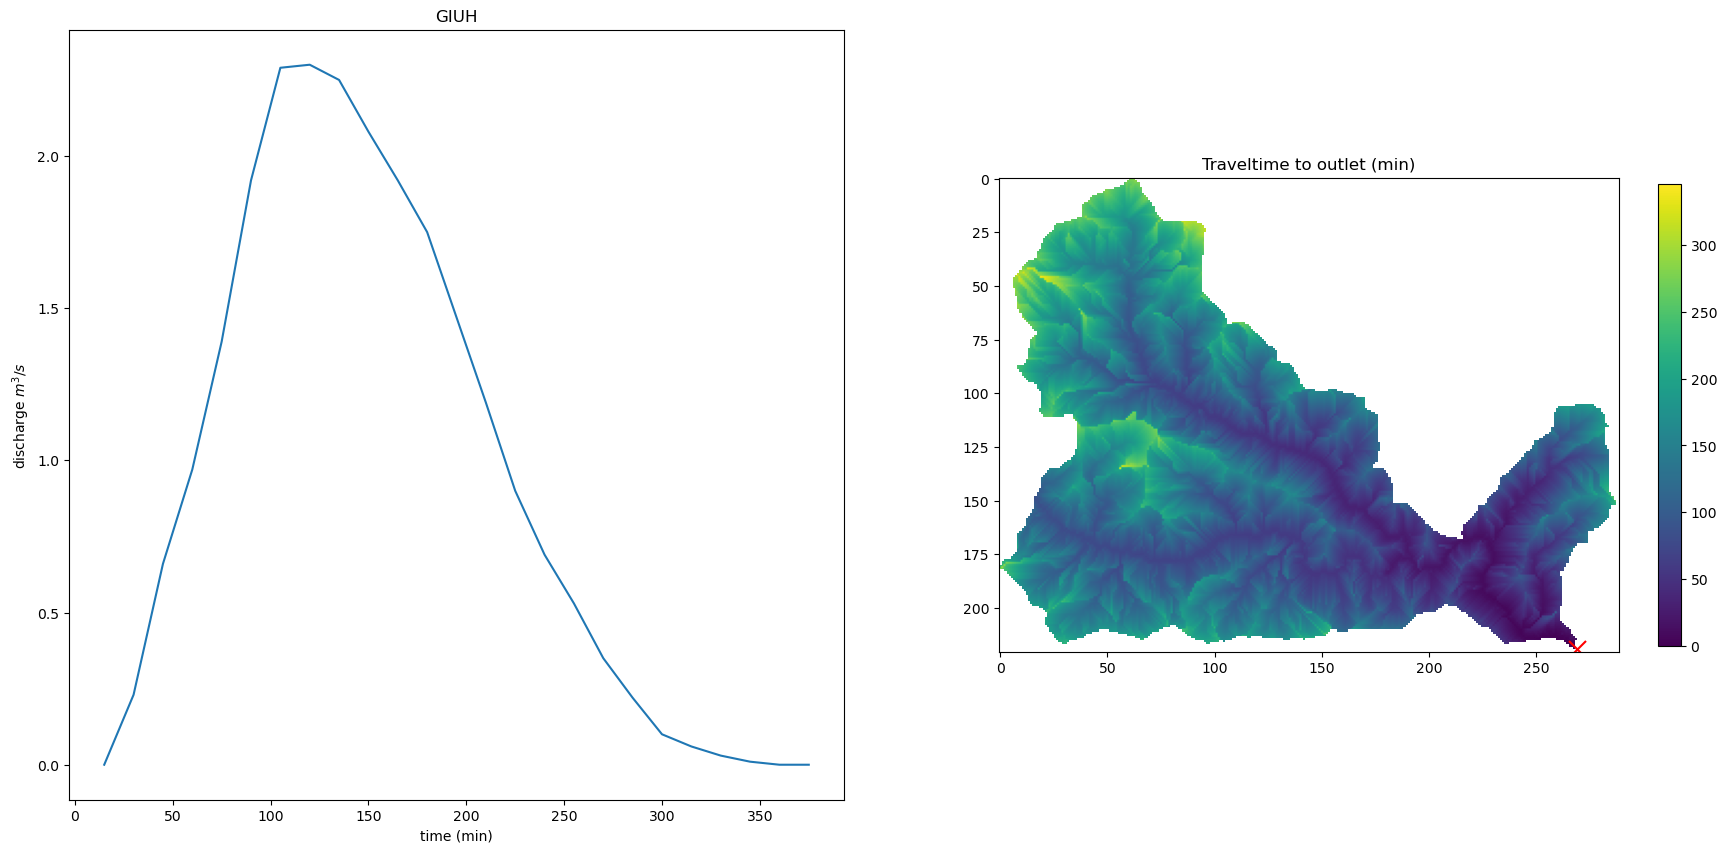

In [7]:
subbasin_id = 46
Image(f'output/giuh_plots/{subbasin_id}_giuh.png')

## Flow order 
Now that all the files for the subbasins are generated, we canthe derive the information, which subbasins are headwater basins and which subbasins are flowing into each other. We can also determine how long it takes the flow to reach the next downstream outlet. All this information is needed later for the hydrological modelling and the superposition of the hydrographs. The information is stored in the file **/input/generated/floworder.csv**.
Additionally, we store this information for every subbasin in a shapefile which comes in handy for later analysis (**input/generated/subbasins_info.gpkg**).

In [7]:
cp.get_floworder()

Sub 1
Sub 2
Sub 3
Sub 4
Sub 5
Sub 6
Sub 7
Sub 8
Sub 9
Sub 10
Sub 11
Sub 12
Sub 13
Sub 14
Sub 15
Sub 16
Sub 17
Sub 18
Sub 19
Sub 20
Sub 21
Sub 22
Sub 23
Sub 24
Sub 25
Sub 26
Sub 27
Sub 28
Sub 29


/home/voit/GIUH/paper_repo/counterfactual_flash_flood_analysis/counterfactual_preparation.py:722: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-340282346638528859811704183484516925440' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.sub_id == id, 'time_to_next_outlet'] = tt_to_next_outlet


Sub 30
Sub 31
Sub 32
Sub 33
Sub 34
Sub 35
Sub 36
Sub 37
Sub 38
Sub 39
Sub 40
Sub 41
Sub 42
Sub 43
Sub 44
Sub 45
Sub 46
Sub 47
Sub 48
Sub 49
Sub 50
Sub 51
Sub 52
Sub 53
Sub 54
Sub 55
Sub 56
Sub 57
Attention, outlet is a pit!
Nr. Problematic subs: 0
Writing cleaned up subbasin file
Nr. Problematic subs: 0
Getting floworder
Subbasin 57 contains a pit
Order: 2
9 subs remaining
Order: 3
8 subs remaining
Order: 4
7 subs remaining
Order: 5
6 subs remaining
Order: 6
5 subs remaining
Order: 7
4 subs remaining
Order: 8
3 subs remaining
Order: 9
2 subs remaining
Order: 10
1 subs remaining
Order: 11
0 subs remaining


OverflowError: Python int too large to convert to C long

If all these steps functioned correctly, you can now proceed to "Part 2 - Rainfall input"

In case you want to try to process other rasters, you can convert them to PCRaster-format like this:
`os.system(f'gdal_translate -of "PCRaster" -a_srs EPSG:3035 {input_path}dem.tif {input_path}dem.map')`